In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import os, glob
from os.path import expanduser

import llops as yp
import matplotlib.pyplot as plt
import numpy as np

yp.config.setDefaultBackend('numpy')
yp.config.setDefaultDatatype('float32')

# plt.style.use('deblur')

In [2]:
# figure_directory = '/home/sarah/Dropbox/deblurring/Phase-Deblurring/journalpaper/figures'
figure_directory = '/home/sarah/Desktop'



In [3]:
def noise_snr(signal, noise_roi=None, signal_roi=None, debug=False):
    """ Calculate the imaging signal to noise ratio (SNR) of a signal """
    # Reference: https://en.wikipedia.org/wiki/Signal-to-noise_ratio_(imaging)

    # Calculate signal mean, using ROI if provided
    signal_mean = yp.mean(signal) if signal_roi is None else yp.mean(signal[signal_roi.slice])

    # Calculate noise standard deviation, using ROI if provided
    signal_std = yp.std(signal) if noise_roi is None else yp.std(signal[noise_roi.slice])

    if debug:
        print('Mean is %g, std is %g' % (yp.scalar(signal_mean), yp.scalar(signal_std)))

    return yp.scalar(signal_mean / signal_std)

# Reconstruction comparisons

Comparing regularization schemes for beads and res target

In [4]:
beads = True
regplot = 'selected'

recon_path = '/home/deansarah/deblurring/datasets/regularized_output/'
if beads:
    filename = 'beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36_ss=1_regularize=' #[].npz'
else:
    filename = 'res_line_bright_coded_raster_100_motion_deblur_2019_02_05_10_52_50_ss=1_regularize=' #[].npz'

reg_dict = {}
if beads:
#     reg_dict['tv'] = ['[]','[tv1.0e-05]','[tv5.0e-05]','[tv1.0e-04]','[tv5.0e-04]']
    reg_dict['tv'] = ['[]','[tv1.0e-05]','[tv5.0e-05]','[tv1.0e-04]','[tv5.0e-04]']
#     reg_dict['tsvd'] = ['[]','[tsvd1.0e+02]','[tsvd5.0e+02]','[tsvd1.0e+03]','[tsvd5.0e+03]','[tsvd1.0e+04]','[tsvd5.0e+04]','[tsvd1.0e+05]','[tsvd5.0e+05]']
#     reg_dict['tsvd'] = ['[]','[tsvd5.0e+05]','[tsvd1.0e+06]','[tsvd1.0e+07]']
    reg_dict['tsvd'] = ['[]','[tsvd1.0e+06]','[tsvd1.0e+07]']
#     reg_dict['l2'] = ['[]','[l21.0e-05]','[l25.0e-05]','[l21.0e-04]','[l25.0e-04]','[l21.0e-03]','[l21.0e-02]']
    reg_dict['l2'] = ['[]','[l28.0e-03]','[l21.0e-02]']
#     reg_dict['haar_wavelet'] = ['[]','[haar_wavelet1.0e-05]','[haar_wavelet5.0e-05]','[haar_wavelet1.0e-04]','[haar_wavelet5.0e-04]','[haar_wavelet1.0e-03]']
    reg_dict['haar_wavelet'] = ['[]','[haar_wavelet1.0e-04]','[haar_wavelet5.0e-04]','[haar_wavelet1.0e-03]']
    reg_dict['median'] = ['[]','[median1.0e-03]','[median1.0e-02]']
    reg_dict['median_filter'] = ['[]','[median_filter1.0e+00]']
    reg_dict['best_of_each'] = ['[]','[l28.0e-03]','[tsvd1.0e+07]','[haar_wavelet5.0e-04]','[tv5.0e-05]','[median1.0e-02]','[median_filter1.0e+00]']
    reg_dict['selected'] = ['[]','[l28.0e-03]','[median1.0e-02]']
else:
    reg_dict['tv'] = ['[]','[tv1.0e-05]','[tv5.0e-05]','[tv1.0e-04]','[tv5.0e-04]','[tv1.0e-03]']
    reg_dict['l2'] = ['[]','[l21.0e-05]','[l21.0e-04]','[l21.0e-03]','[l21.0e-02]']
    reg_dict['haar_wavelet'] = ['[]','[haar_wavelet1.0e-05]','[haar_wavelet1.0e-04]','[haar_wavelet1.0e-03]']
    reg_dict['tsvd'] = ['[]','[tsvd1.0e+06]','[tsvd1.0e+07]']

regs = reg_dict[regplot]


<IPython.core.display.Javascript object>


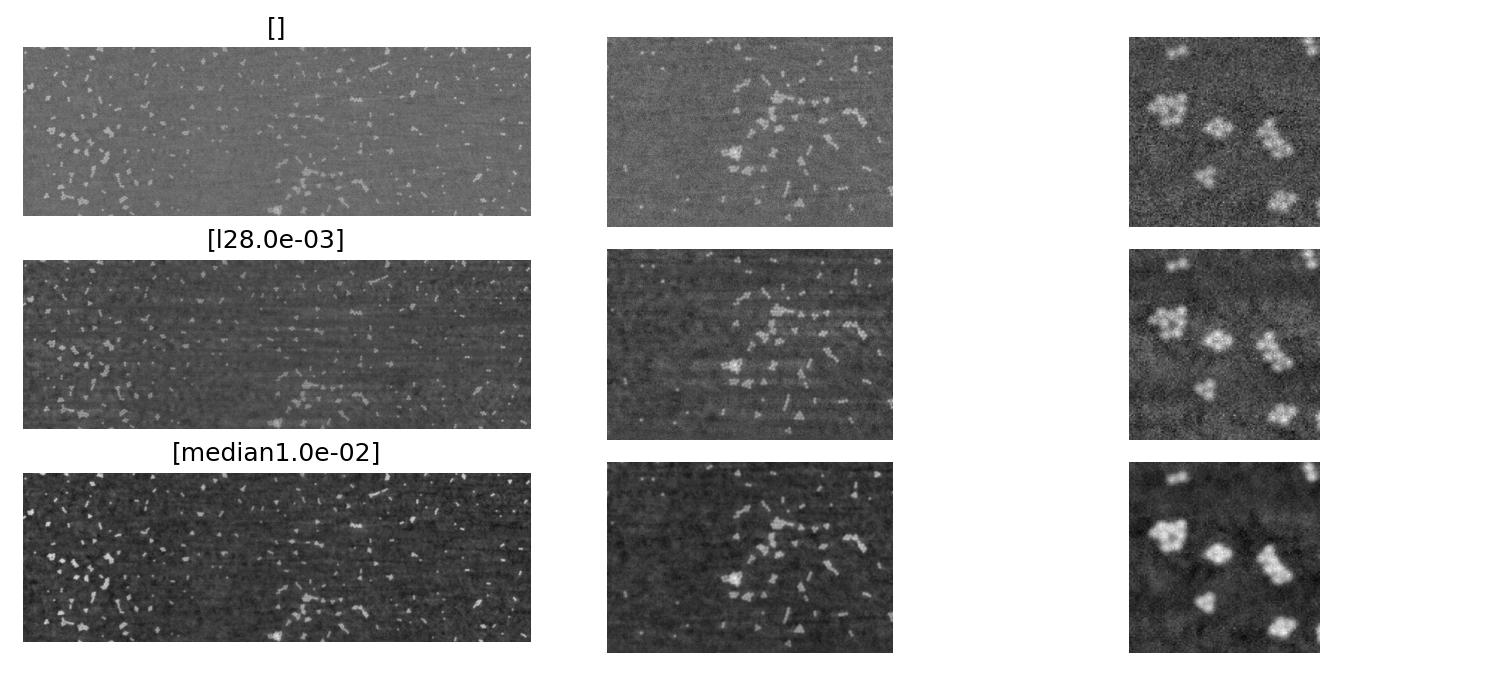

/home/deansarah/deblurring/datasets/regularized_output/comparison_selected_multiscale_beads.png


In [5]:
if beads:
    roi_crop_A = yp.Roi(start=(950, 4000), shape=(512, 1536))
    roi_crop_A2 = yp.Roi(start=(1200, 4500), shape=(400, 600))
    roi_crop_B_0 = yp.Roi(start=(1044-32, 4501), shape=(128, 128))
    roi_crop_B_1 = yp.Roi(start=(1465-32, 4735), shape=(128, 128))
    roi_crop_B_2 = yp.Roi(start=(1178-32+10, 4049+10), shape=(128, 128))
    roi_crop_B = roi_crop_B_2

    min_val = 300
    max_val = 4000
else:
    roi_crop_B_0 = yp.Roi(start=(1000-75,4950-25), shape=(300,300))
    roi_crop_B_1 = yp.Roi(start=(462-75,5228), shape=(300,300))
    roi_crop_B_2 = yp.Roi(start=(1324-75,5350), shape=(300,300))
    archive = np.load(recon_path + filename + regs[0] + '.npz')
    obj = np.real(archive['object_recovered'])
    roi_crop_A = yp.Roi(start=(0,0), shape=obj.shape)
    roi_crop_A2 = roi_crop_B_0
    
    max_val = 20000
    min_val = 0

plt.figure(figsize=(10,1.5*len(regs)))
for i,reg in enumerate(regs):
    archive = np.load(recon_path + filename + reg + '.npz')
    obj = np.real(archive['object_recovered'])
    
    plt.subplot(len(regs),3,3*i+1)
    plt.imshow(obj[roi_crop_A.slice], cmap='gray')
    plt.axis('off')
#     plt.clim((min_val, max_val))
#     roi_crop_A.draw(plt.gca(), c='b')
    plt.title(reg)
    
    plt.subplot(len(regs),3,3*i+2)
    plt.imshow(obj[roi_crop_A2.slice], cmap='gray')
    plt.axis('off')
#     plt.clim((min_val, max_val))
    if beads:
#         (roi_crop_B - roi_crop_A.start).draw(plt.gca(), c='b')

        plt.subplot(len(regs),3,3*i+3)
        plt.imshow(obj[roi_crop_B.slice], cmap='gray')
        plt.axis('off')
#         plt.clim((min_val, max_val))
plt.tight_layout()
tag = 'beads' if beads else 'res'
savepath = recon_path+'comparison_{}_multiscale_{}.png'.format(regplot,tag)
print(savepath)

## SNR Comparisons

<IPython.core.display.Javascript object>


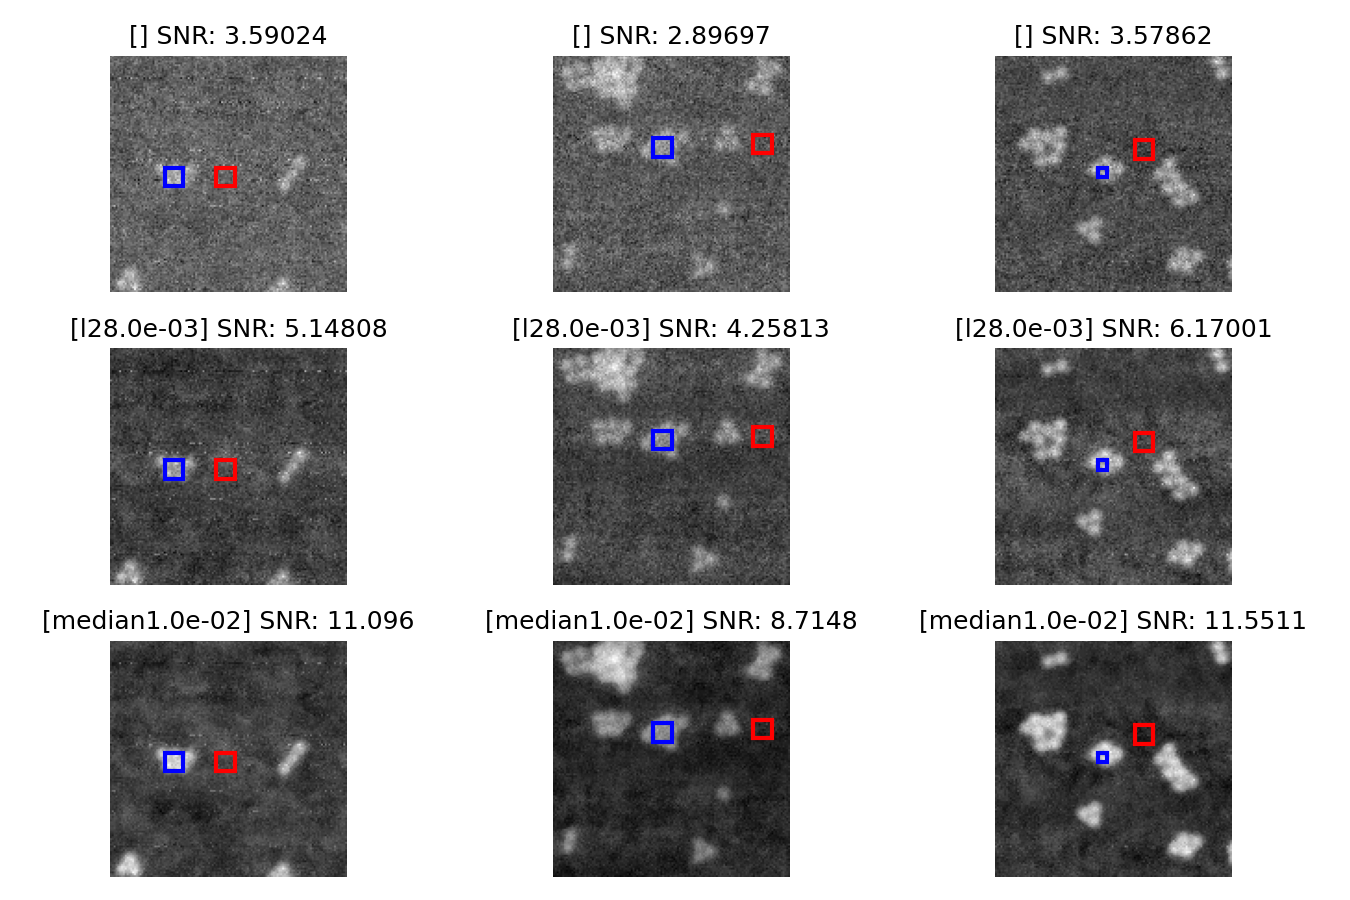

/home/deansarah/deblurring/datasets/regularized_output/comparison_selected_snr_beads.png


In [6]:
plt.figure(figsize=(9,2*len(regs)))
roi_list = (roi_crop_B_0, roi_crop_B_1, roi_crop_B_2)

if beads:
    signal_roi_list = (yp.Roi(start=(60,29), shape=(10,10)), yp.Roi(start=(44,54), shape=(10,10)), yp.Roi(start=(60,55), shape=(5,5)))
    noise_roi_list = (yp.Roi(start=(60,57), shape=(10,10)), yp.Roi(start=(42,108), shape=(10,10)), yp.Roi(start=(45,75), shape=(10,10)))
    mean_bg_value = 378
else:
    noise_roi_list = (yp.Roi(start=(193, 175), shape=(10,10)), yp.Roi(start=(101,140), shape=(15,15)), yp.Roi(start=(100,226), shape=(10,10)))
    signal_roi_list = (yp.Roi(start=(190,135), shape=(25,25)), yp.Roi(start=(100,38), shape=(25,25)), yp.Roi(start=(100,190), shape=(25,25)))
    mean_bg_value = 0

subfig_counter = 1
for i,reg in enumerate(regs):
    archive = np.load(recon_path + filename + reg + '.npz')
    obj = np.real(archive['object_recovered'])
    for index, (roi, signal_roi, noise_roi) in enumerate(zip(roi_list, signal_roi_list, noise_roi_list)):
        obj_crop = obj[roi.slice] - mean_bg_value
        snr_obj = noise_snr(obj_crop, signal_roi=signal_roi, noise_roi=noise_roi)


        plt.subplot(len(regs),len(roi_list), subfig_counter)
        plt.imshow(obj_crop, cmap='gray')
        plt.axis('off')
        signal_roi.draw(plt.gca(), c='b')
        noise_roi.draw(plt.gca(), c='r')
        plt.title(reg+' SNR: %g' % snr_obj)
        subfig_counter+=1

plt.tight_layout()
tag = 'beads' if beads else 'res'
savepath = recon_path+'comparison_{}_snr_{}.png'.format(regplot,tag)
print(savepath)

# Creating images for figure

<IPython.core.display.Javascript object>


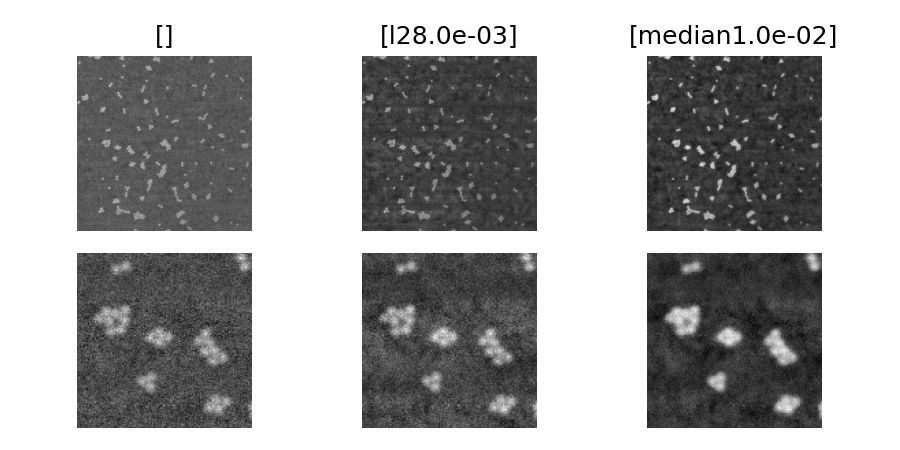

/home/deansarah/deblurring/datasets/regularized_output/comparison_selected_multiscale_beads.png


In [7]:
if beads:
    roi_crop_A = yp.Roi(start=(950, 4000), shape=(512, 512))
    roi_crop_B_0 = yp.Roi(start=(1044-32, 4501), shape=(128, 128))
    roi_crop_B_1 = yp.Roi(start=(1465-32, 4735), shape=(128, 128))
    roi_crop_B_2 = yp.Roi(start=(1178-32+10, 4049+10), shape=(128, 128))
    roi_crop_B = roi_crop_B_2

    min_val = 300
    max_val = 4000
else:
    assert False

plt.figure(figsize=(6,3))
for i,reg in enumerate(regs):
    archive = np.load(recon_path + filename + reg + '.npz')
    obj = np.real(archive['object_recovered'])
    
    # TODO: add in SNS
    
    plt.subplot(2,len(regs),i+1)
    plt.imshow(obj[roi_crop_A.slice], cmap='gray')
    plt.axis('off')
#     plt.clim((min_val, max_val))
#     roi_crop_B.draw(plt.gca(), c='y')
    plt.title(reg)
    
    plt.subplot(2,len(regs),len(regs)+i+1)
    plt.imshow(obj[roi_crop_B.slice], cmap='gray')
    plt.axis('off')
#   plt.clim((min_val, max_val))
plt.tight_layout()
tag = 'beads' if beads else 'res'
savepath = recon_path+'comparison_{}_multiscale_{}.png'.format(regplot,tag)
print(savepath)